# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: Unknown error (0x80092012) - The revocation function was unable to check revocation for the certificate.
x Train_rev1.csv


(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

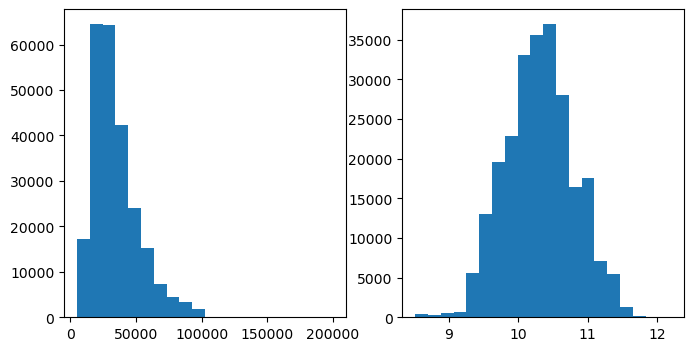

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
10224,66314422,Gas and Plumbling Engineers PERMANENT,We are currently recruiting nationally on beha...,Newcastle upon Tyne,Newcastle Upon Tyne,NaN,NaN,Forde Recruitment,Engineering Jobs,34212 + VAN + BENEFITS,34212,MyUkJobs,10.440361
51432,68636005,Web Developer,Web Developer **** **** The opportunity to w...,Manchester,Manchester,NaN,permanent,NaN,IT Jobs,25000.00 - 30000.00 per annum,27500,theitjobboard.co.uk,10.221977
148363,70760265,Customer Service Advisor,A great Customer Service Advisor is needed for...,"Colchester, Essex",Colchester,NaN,permanent,Prime Appointments,Customer Services Jobs,15000/annum Commission,15000,cv-library.co.uk,9.615872


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [5]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
data['FullDescription'] = data['FullDescription'].apply(str.lower)
data['Title'].fillna('nan', inplace=True)
data['Title'] = data['Title'].apply(str.lower)

data['FullDescription'] = data['FullDescription'].apply(tokenizer.tokenize)
data['FullDescription'] = data['FullDescription'].apply(' '.join)
data['Title'] = data['Title'].apply(tokenizer.tokenize)
data['Title'] = data['Title'].apply(' '.join)

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("Tokenized:")
print(data["FullDescription"][2][:50], data["Title"][54321])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
mathematical modeller / simulation analyst / opera international digital account manager ( german )


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter

token_counts = Counter()

for i in data['Title']:
    for j in i.split():
        token_counts[j] += 1
        
for i in data['FullDescription']:
    for j in i.split():
        token_counts[j] += 1

print(len(token_counts))

202704


In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


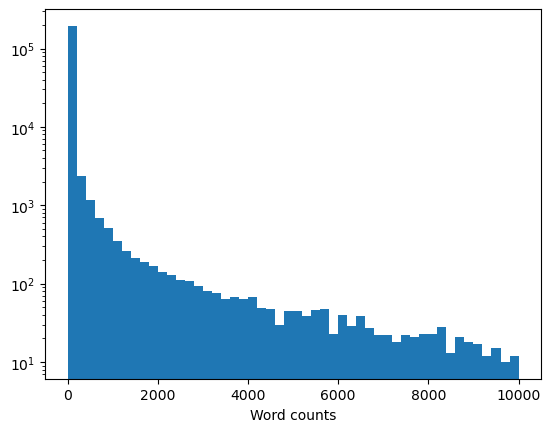

In [10]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Text(0.5, 0, 'description length')

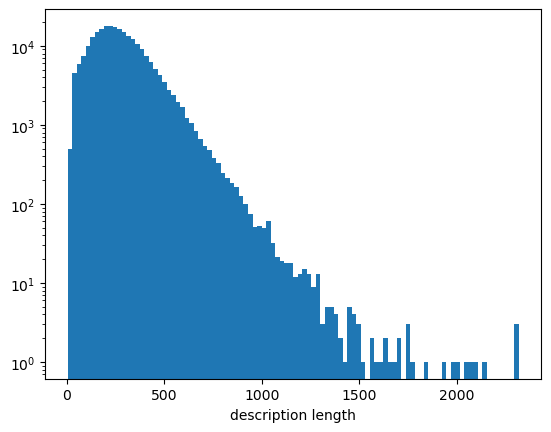

In [11]:
plt.hist(data['FullDescription'].apply(lambda x: x.count(' ')), bins=100, log=True)
plt.xlabel("description length")

Now filter tokens a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [k for k, v in token_counts.items() if v>=min_count]

In [13]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
token_to_id = dict((k, ind) for ind, k in enumerate(tokens))

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you use more advanced encodings: tf-idf, pretrained w2v etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
import gensim.downloader
#fasttext_enc = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [21]:
#fasttext_enc.save('fasttext_300_local')

In [22]:
from gensim.models import KeyedVectors
fasttext_enc = KeyedVectors.load("fasttext_300_local")
fasttext_enc['hi'].shape

(300,)

In [23]:
tokens = np.array(tokens)

In [24]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, min((max_len or float('inf')), 40))
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    """
    batch = {'Title':np.array([[fasttext_enc[j] if j in fasttext_enc else fasttext_enc['UNK'] for j in i] for i in tokens[batch['Title']]]),
               'FullDescription':np.array([[fasttext_enc[j] if j in fasttext_enc else fasttext_enc['UNK'] for j in i] for i in tokens[batch['FullDescription']]]),
               #'Categorical':[[fasttext_enc[j] if j in fasttext_enc else fasttext_enc['UNK'] for j in i] for i in tokens[dummy_batch['Categorical'].astype(int)]],
               'Categorical':batch['Categorical'],
               'Log1pSalary':batch['Log1pSalary']}
    """
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [25]:
for k, v in make_batch(data_train[:10], max_len=10).items():
    print(k, v.shape)

Title (10, 10)
FullDescription (10, 10)
Categorical (10, 3768)
Log1pSalary (10,)


#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [26]:
import keras
import keras.layers as L
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L1

In [27]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    emb_l = L.Embedding(input_dim=n_tokens,
                        output_dim=300,
                        weights=np.array([[fasttext_enc[tokens[i]] if tokens[i] in fasttext_enc else
                                          fasttext_enc['UNK'] for i in range(n_tokens)]])
                       )
    
    x = L.Masking(PAD_IX)(l_title)
    x = emb_l(x)
    x = L.Dense(120, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x1 = L.Dense(20, activation='relu')(x)
    x2 = L.Dense(20, activation='relu')(x)
    x3 = L.Dense(20, activation='relu')(x)
    x = L.MultiHeadAttention(3, 20, name='Attention_T')(x1, x2)
    
    x1 = L.GlobalMaxPooling1D(name='maxpool_T')(x)
    x2 = L.GlobalAveragePooling1D(name='avgpool_T')(x)
    outp1 = L.Concatenate()([x1, x2])
    
    
    x = L.Masking(PAD_IX)(l_descr)
    x = emb_l(x)
    x = L.Dense(160, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x1 = L.Dense(30, activation='relu')(x)
    x2 = L.Dense(30, activation='relu')(x)
    x4 = L.Dense(30, activation='relu')(x)
    x = L.MultiHeadAttention(3, 30, name='Attention_D')(x1, x2)
    
    x1 = L.GlobalMaxPooling1D(name='maxpool_D')(x)
    x2 = L.GlobalAveragePooling1D(name='avgpool_D')(x)
    outp2 = L.Concatenate()([x1, x2])
    
    x = L.MultiHeadAttention(3, 30, name='Attention_12')(x3, x4)
    x1 = L.GlobalMaxPooling1D(name='maxpool_12')(x)
    x2 = L.GlobalAveragePooling1D(name='avgpool_12')(x)
    outp4 = L.Concatenate()([x1, x2])
    
    x = L.Dense(40, activation='relu', name='c_dense1')(l_categ)
    x = L.Dense(40, activation='relu', name='c_dense2')(x)
    outp3 = L.Dense(10, activation='relu', name='c_dense3')(x)
    
    outp1 = L.Flatten()(outp1)
    outp2 = L.Flatten()(outp2)
    outp3 = L.Flatten()(outp3)
    outp4 = L.Flatten()(outp4)
    
    x = L.Concatenate()([outp1, outp2, outp3, outp4])
    x = L.BatchNormalization()(x)
    x = L.Dense(50, activation='relu', kernel_regularizer=L1(0.01))(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(10, activation='relu')(x)
    output_layer = L.Dense(1, activation='linear', name='Log1pSalary')(x)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

#build_model().summary()
#mdl = build_model()
#plot_model(mdl, 'model_LSTM_1.png', show_shapes=True, show_layer_names=True,)

In [28]:
model = build_model()
model.summary()

dummy_batch = make_batch(data_train[:100], 10)
for k,v in dummy_batch.items():
    print(k, np.array(v).shape)

print('here')
dummy_pred = model.predict(dummy_batch)
print(dummy_pred)
print('here2')
dummy_loss = model.train_on_batch(dummy_batch, dummy_batch['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 masking (Masking)              (None, None)         0           ['Title[0][0]']                  
                                                                                                  
 masking_1 (Masking)            (None, None)         0           ['FullDescription[0][0]']        
                                                                                              

                                                                                                  
 concatenate_3 (Concatenate)    (None, 150)          0           ['flatten[0][0]',                
                                                                  'flatten_1[0][0]',              
                                                                  'flatten_2[0][0]',              
                                                                  'flatten_3[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 150)         600         ['concatenate_3[0][0]']          
 alization)                                                                                       
                                                                                                  
 dense_8 (Dense)                (None, 100)          15100       ['batch_normalization[0][0]']    
          

C:\Users\movse\anaconda3\envs\UpToDateEnv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4/4 [==============================] - 0s 2ms/step
[[ 8.4659946e-04]
 [-4.3956656e-04]
 [-8.1775896e-04]
 [-1.5917271e-03]
 [-2.7550114e-03]
 [-7.9281982e-03]
 [ 3.0062022e-04]
 [ 1.8767987e-03]
 [-5.1954761e-05]
 [ 4.2716595e-03]
 [-4.8773251e-03]
 [ 3.2805735e-03]
 [ 2.3732767e-03]
 [-1.2779777e-03]
 [-3.0152434e-03]
 [ 1.1140518e-03]
 [-6.1706845e-03]
 [ 5.8254926e-05]
 [-5.8865547e-04]
 [-3.5285829e-03]
 [ 4.0452536e-03]
 [-1.7560693e-04]
 [ 3.2946081e-03]
 [ 1.9158283e-04]
 [ 3.1676609e-03]
 [-9.5217489e-05]
 [-6.0244976e-04]
 [-8.7870075e-04]
 [-1.3940237e-03]
 [-2.0903070e-05]
 [-8.4531000e-03]
 [-5.0830916e-03]
 [ 4.0455447e-03]
 [-4.6606795e-03]
 [-2.6217788e-03]
 [ 1.3630588e-03]
 [-3.0072760e-03]
 [-6.7033898e-04]
 [ 1.3364151e-03]
 [ 4.4437824e-04]
 [-2.5494974e-03]
 [-1.0568989e-03]
 [-6.0603325e-03]
 [ 5.4782345e-03]
 [-4.2669073e-04]
 [-4.2638946e-03]
 [-4.9112537e-03]
 [ 4.3934938e-03]
 [ 1.1135248e-03]
 [ 1.0761688e-03]
 [-2.2528362e-03]
 [-4.2816880e-03]
 [ 4.3298258e

In [29]:
dummy_batch['FullDescription'].shape

(100, 10)

#### Training and evaluation

As usual, we gonna feed our model with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [29]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [30]:
batch_size = 32
epochs = 100
steps_per_epoch = 200  #(len(data_train) - 1) // batch_size + 1

early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

model = build_model()

history4 = model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),
                     epochs=epochs, steps_per_epoch=steps_per_epoch,
                     
                     validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                     validation_steps=data_val.shape[0] // batch_size,
                     callbacks=[early_stopping]
                    )

Epoch 1/100
200/200 [==============================] - 207s 1s/step - loss: 22.4629 - mean_absolute_error: 2.4371 - val_loss: 14.1788 - val_mean_absolute_error: 1.8472
Epoch 2/100
200/200 [==============================] - 205s 1s/step - loss: 9.2736 - mean_absolute_error: 0.9148 - val_loss: 7.9357 - val_mean_absolute_error: 0.7542
Epoch 3/100
200/200 [==============================] - 207s 1s/step - loss: 6.6519 - mean_absolute_error: 0.7118 - val_loss: 10.3253 - val_mean_absolute_error: 2.1839
Epoch 4/100
200/200 [==============================] - 211s 1s/step - loss: 4.7929 - mean_absolute_error: 0.5968 - val_loss: 5.9364 - val_mean_absolute_error: 1.4599
Epoch 5/100
200/200 [==============================] - 207s 1s/step - loss: 3.5063 - mean_absolute_error: 0.5480 - val_loss: 3.0090 - val_mean_absolute_error: 0.5602
Epoch 6/100
200/200 [==============================] - 212s 1s/step - loss: 2.5942 - mean_absolute_error: 0.5210 - val_loss: 1.9765 - val_mean_absolute_error: 0.3175
E

In [34]:
model.save('Attention_2.h5')

In [62]:
#model1 =  tf.keras.models.load_model('LSTM_v1.h5')
#model1.summary()

batch_size = 32 everywhere

steps_per epoch = 1000 everywhere except model4 (200 in model4)

***________________________________________________________________________________________________________________________***

#### model1:

***Fasttext embeddings*** - <font color='red'>Not trainable</font>

***Bidirectional LSTM*** for Title and Description

***Avg_pool*** + ***max_pool*** from Title and Description after LSTM

***Dropout*** and ***batch normalization*** at the end

***________________________________________________________________________________________________________________________***

#### model2:

***Fasttext embeddings*** - <font color='green'>Trainable</font>

Added ***dropout***  to ***LSTM***

Added masking layer so the model doesnt pay attention to paddings

    pros: avg_pool should benefit from this, is faster
    
    cons: creates more graphs
    
Rest is the same

***________________________________________________________________________________________________________________________***

#### model3:

Replaced ***LSTM*** with ***Attention***

    pros: much faster, better scores, more stable training
    
    cons: requires slightly more memory
    
Rest is the same


***________________________________________________________________________________________________________________________***


### model4:

#### Attention -> MultiHeadAttention

***____ pros: better performance, faster convergence epoch-wise***.

***____ cons: works much slower, needs more memory***.

#### Added 4-th branch that uses Title as query and Description as key/value so that the attention can pick up words based on Title's context

#### Added L1 regularization after the concatenation layer to avoid multicollinearity
    
#### Rest is the same

***________________________________________________________________________________________________________________________***

Other potential improvements:

Adding positional (sin/cos) embeddings.

In [53]:
print('hi')

In [32]:
def plt_history(h):
    plt.plot(h.history['mean_absolute_error'], label='mae')
    plt.plot(h.history['loss'], label='mse')
    plt.plot(h.history['val_mean_absolute_error'], label='val_mae')
    plt.plot(h.history['val_loss'], label='val_mse')
    plt.legend()
    plt.show()
    
    arg_min1 = np.argmin(h.history['val_loss'])
    print('mae =', h.history['mean_absolute_error'][arg_min1])
    print('mse =', h.history['loss'][arg_min1])
    print('val_mae =', h.history['val_mean_absolute_error'][arg_min1])
    print('val_mse =', h.history['val_loss'][arg_min1])

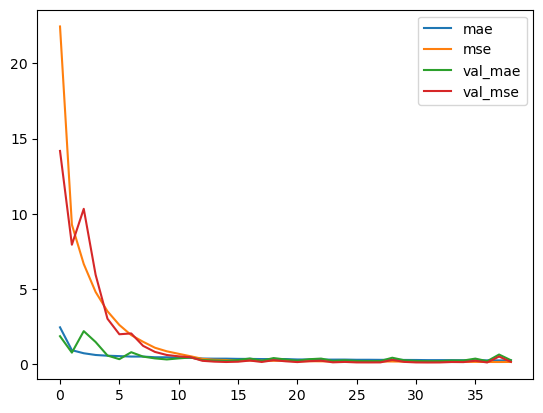

mae = 0.254819393157959
mse = 0.14414776861667633
val_mae = 0.18570296466350555
val_mse = 0.09789654612541199


In [33]:
# each epoch is 5 times smaller than in other models
plt_history(history4)

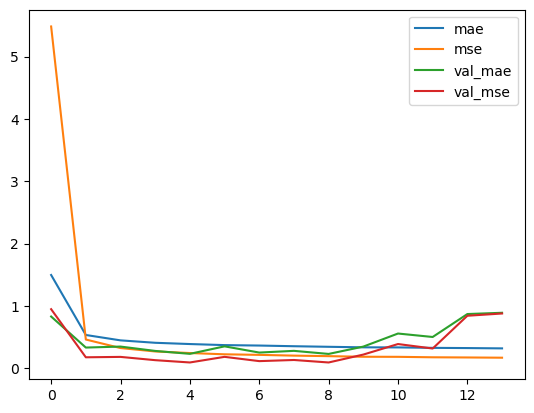

mae = 0.3450976610183716
mse = 0.19489867985248566
val_mae = 0.23055356740951538
val_mse = 0.09350360184907913


In [33]:
plt_history(history3)

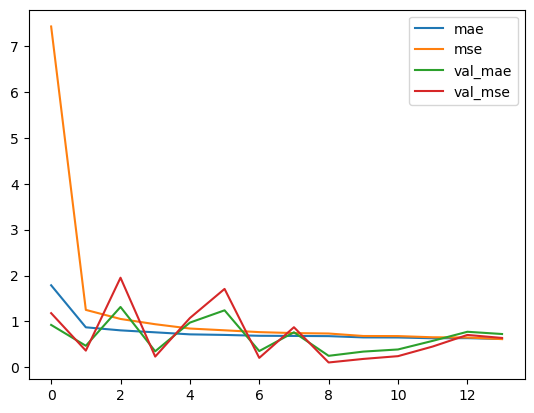

mae = 0.6806453466415405
mse = 0.7377350330352783
val_mae = 0.2520613670349121
val_mse = 0.10699072480201721


In [37]:
plt_history(history2)

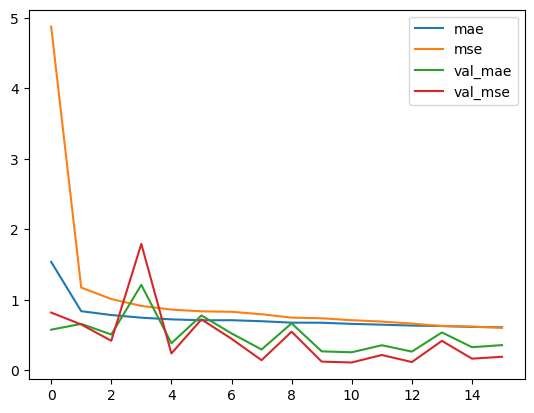

mae = 0.6095054149627686
mse = 0.6021668314933777
val_mae = 0.3570358157157898
val_mse = 0.1918124109506607


In [54]:
plt_history(history1)

In [36]:
# this cell creates too many graphs
"""
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train[:200], 64, name='Train')
print_metrics(model, data_val[:200], 64, name='Val');
"""

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [37]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [38]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [40]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

test_batch1 = make_batch(data.iloc[i:i+1])
preds = model.predict(test_batch1)
print('salary pred. -', preds[0, 0])
print('ground truth -', data.loc[i, 'Log1pSalary'])

1/1 [==============================] - 0s 24ms/step


sales specialist iv access and infusion

11/11 [==============================] - 0s 44ms/step


sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

1/1 [==============================] - 0s 14ms/step
salary pred. - 10.745989
ground truth - 10.434145


In [41]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

test_batch1 = make_batch(data.iloc[i:i+1])
preds = model.predict(test_batch1)
print('salary pred. -', preds[0, 0])
print('ground truth -', data.loc[i, 'Log1pSalary'])

C:\Users\movse\anaconda3\envs\UpToDateEnv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 282ms/step


cleaning operative

3/3 [==============================] - 0s 4ms/step


12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

1/1 [==============================] - 0s 13ms/step
salary pred. - 8.999432
ground truth - 9.383033


In [262]:
## don't run this cell it contains the example.

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [42]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

test_batch1 = make_batch(data.iloc[i:i+1])
preds = model.predict(test_batch1)
print('salary pred. -', preds[0, 0])
print('ground truth -', data.loc[i, 'Log1pSalary'])

Index: 217334
1/1 [==============================] - 0s 15ms/step
Salary (gbp): 31074.57
1/1 [==============================] - 0s 17ms/step


buyer branded cosmetics

7/7 [==============================] - 0s 25ms/step


the uk ' s leading beauty retailer currently has an exciting opportunity within their expanding team for a UNK buyer . this retailer has a national presence and is a staple of every uk high street . their customer service approach is outstanding and their company culture respects work life balance . the ideal candidate will be at buyer or junior buyer level . they do not necessarily need to have brought cosmetics in the past but will show passion for fragrance and beauty . a large part of your role will be to establish strong relationships with suppliers and so a proven track record of this is essential . you must have bags of personality and be able to drive the business forward . this is an exceptional opportunity for the right person who is looking for the next step within their buying career . we regret that due to volume , only shortlisted applicants will be contacted , therefore if you do not hear from one of our consultants within **** working days , please assume that you ' ve not been successful on this occasion . fashion and retail personnel is acting as an employment agency in relation to this vacancy . this job was originally posted as www . retailchoice . com / jobseeking / UNK ****

1/1 [==============================] - 0s 14ms/step
salary pred. - 10.344177
ground truth - 10.389026


__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)